### Importing libraries

In [1]:
import pandas as pd
from collections import defaultdict
import math
import numpy as np
from decimal import Decimal
import scipy.ndimage
import matplotlib.pyplot as plt

In [271]:
file_path1 = 'testDataforTOI/amblypiaStudyTest2 Data Export.tsv'
# file_path2 = 'TestData/amblyopiaStudy MetricsSanaTest.tsv'

dataExport = pd.read_csv(file_path1, sep='\t')
# dataMetric = pd.read_csv(file_path2, sep='\t')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 10)


In [272]:
# display(dataExport.columns[0:50])
# print(dataExport['Recording resolution height'])
# print(dataExport['Recording resolution width'])
# print(dataExport['Viewport position X'])
# print(dataExport['Viewport width'])
# print(dataExport['Original Media height'])

Checking to find the end of calibration index

In [273]:

dataExport[dataExport.eq("Eyetracker Calibration").any(1)]['Presented Stimulus name']

197     Eyetracker Calibration
198     Eyetracker Calibration
199     Eyetracker Calibration
200     Eyetracker Calibration
201     Eyetracker Calibration
                 ...          
5277    Eyetracker Calibration
5278    Eyetracker Calibration
5279    Eyetracker Calibration
5280    Eyetracker Calibration
5281    Eyetracker Calibration
Name: Presented Stimulus name, Length: 5076, dtype: object

In [274]:
calibrationEnd = dataExport[dataExport.eq("Eyetracker Calibration").any(1)]['Presented Stimulus name'].index.to_list()[-1]
calibrationEnd+=1


### Extracting features

In [275]:
dataExport = dataExport[["Eyetracker timestamp", "Event", "Event value", "Gaze point X (MCSnorm)", "Gaze point Y (MCSnorm)", "Eye movement type", 
    "Presented Stimulus name", 'AOI hit [slothStimulus-final (1) - sloth1]',
       'AOI hit [slothStimulus-final (1) - sloth2]',
       'AOI hit [slothStimulus-final (1) - sloth3]',
       'AOI hit [slothStimulus-final (1) - sloth4]',
       'AOI hit [slothStimulus-final (1) - sloth5]',
       'AOI hit [slothStimulus-final (1) - sloth6]',
       'AOI hit [slothStimulus-final (1) - sloth7]',
       'AOI hit [slothStimulus-final (1) - sloth8]',
       'AOI hit [slothStimulus-final (1) - sloth9]',
       'AOI hit [slothStimulus-final (1) - sloth10]',
       'AOI hit [slothStimulus-final (1) - sloth11]',
       'AOI hit [catStimulus-final (1) - cat1]',
        'AOI hit [catStimulus-final (1) - cat2]',
       'AOI hit [catStimulus-final (1) - cat3]',
       'AOI hit [catStimulus-final (1) - cat4]',
       'AOI hit [catStimulus-final (1) - cat5]',
       'AOI hit [catStimulus-final (1) - cat6]',
       'AOI hit [catStimulus-final (1) - cat7]',
       'AOI hit [catStimulus-final (1) - cat8]',
       'AOI hit [catStimulus-final (1) - cat9]',
       'AOI hit [catStimulus-final (1) - cat10]',
       'AOI hit [catStimulus-final (1) - cat11]',
        'Gaze point left X (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)', 
                         'Gaze point right Y (MCSnorm)']]

display(dataExport)


#Only isolate non calibration data
dataExportWithoutCalibration = dataExport[calibrationEnd:]

#Drop all columns with eye movement type of eyes not found
dataExportWithoutCalibration = dataExportWithoutCalibration[dataExportWithoutCalibration['Eye movement type'] != 'EyesNotFound']

#Convert the x and y coordinates into pixels and then into inches using ppi of 92.
dataExportWithoutCalibration[[ 'Gaze point X (MCSnorm)', 'Gaze point left X (MCSnorm)', 'Gaze point right X (MCSnorm)']] = dataExportWithoutCalibration[[ 'Gaze point X (MCSnorm)', 'Gaze point left X (MCSnorm)', 'Gaze point right X (MCSnorm)']]*20.82 

dataExportWithoutCalibration[[ 'Gaze point Y (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right Y (MCSnorm)']] = dataExportWithoutCalibration[[ 'Gaze point Y (MCSnorm)', 'Gaze point left Y (MCSnorm)', 'Gaze point right Y (MCSnorm)']]*11.71 


#normalizes TIME when the calibration ends and stimulus sloth starts (at 0)
dataExportWithoutCalibration['Eyetracker timestamp'] = dataExportWithoutCalibration['Eyetracker timestamp'] - dataExportWithoutCalibration['Eyetracker timestamp'].iloc[0]

#normalizes TIME when the sloth ends and cats start (at 0)
#find the index where the cat stimulus begins
indices = dataExportWithoutCalibration.index[dataExportWithoutCalibration['Presented Stimulus name'] == "catStimulus-final (1)"]

#Find the beginning time for normalization
beginTime = dataExportWithoutCalibration['Eyetracker timestamp'].loc[indices[0]]
index_of_catBegin = (dataExportWithoutCalibration.index.tolist()).index(indices[0])
onylCat = dataExportWithoutCalibration.index[index_of_catBegin:]
#iterate through all times for cat stimulus and update
for i in onylCat:
    dataExportWithoutCalibration.loc[i, 'Eyetracker timestamp'] = dataExportWithoutCalibration.loc[i, 'Eyetracker timestamp'] - beginTime




,Eyetracker timestamp,Event,Event value,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),...,AOI hit [catStimulus-final (1) - cat11],Gaze point left X (MCSnorm),Gaze point left Y (MCSnorm),Gaze point right X (MCSnorm),Gaze point right Y (MCSnorm)
0,NaN,RecordingStart,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,1.420768e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,1.420776e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,1.420784e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,1.420793e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
12381,1.522368e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
12382,1.522376e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
12383,1.522385e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
12384,1.522393e+09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


### interpolate Data

In [276]:
columns_to_interpolate = ['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)', 'Gaze point left X (MCSnorm)', 
                          'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)']
# Use the subset parameter to interpolate only the specified columns
dataExportWithoutCalibration[columns_to_interpolate] = dataExportWithoutCalibration[columns_to_interpolate].interpolate(method='linear')
nan_df = dataExportWithoutCalibration.isna()  # or df.isnull()

#isolate only saccade data
mask = dataExportWithoutCalibration["Eye movement type"] == "Saccade"
dfSaccade = dataExportWithoutCalibration[mask]

In [277]:
dfSaccade[450:]

,Eyetracker timestamp,Event,Event value,Gaze point X (MCSnorm),Gaze point Y (MCSnorm),...,AOI hit [catStimulus-final (1) - cat11],Gaze point left X (MCSnorm),Gaze point left Y (MCSnorm),Gaze point right X (MCSnorm),Gaze point right Y (MCSnorm)
10991,17816680.0,NaN,NaN,6.223098,4.770654,...,-1.0,5.423610,3.230789,7.024668,6.310519
10992,17825014.0,NaN,NaN,7.195392,4.325674,...,-1.0,6.660318,2.660512,7.732548,5.992007
10993,17833347.0,NaN,NaN,8.546610,3.332666,...,-1.0,8.190588,1.660478,8.900550,5.004854
10994,17841680.0,NaN,NaN,9.471018,2.860753,...,-1.0,9.119160,1.176855,9.824958,4.544651
10995,17850014.0,NaN,NaN,9.929058,2.590252,...,-1.0,9.654234,0.807990,10.203882,4.372514
10997,17866679.0,NaN,NaN,10.012338,2.539899,...,-1.0,9.718776,0.806819,10.305900,4.272979
10998,17875013.0,NaN,NaN,9.791646,2.510624,...,-1.0,9.541806,0.793938,10.039404,4.227310
11002,17908346.0,NaN,NaN,10.004010,2.357223,...,-1.0,10.008174,0.584329,10.001928,4.131288
11015,18016680.0,NaN,NaN,9.812466,2.788151,...,-1.0,9.700038,1.019941,9.922812,4.555190
11016,18025014.0,NaN,NaN,10.172652,3.099637,...,-1.0,10.193472,1.490683,10.153914,4.709762


### Identify the primary saccade 

In [278]:

AOI_list = ['AOI hit [slothStimulus-final (1) - sloth1]',
       'AOI hit [slothStimulus-final (1) - sloth2]',
       'AOI hit [slothStimulus-final (1) - sloth3]',
       'AOI hit [slothStimulus-final (1) - sloth4]',
       'AOI hit [slothStimulus-final (1) - sloth5]',
       'AOI hit [slothStimulus-final (1) - sloth6]',
       'AOI hit [slothStimulus-final (1) - sloth7]',
       'AOI hit [slothStimulus-final (1) - sloth8]',
       'AOI hit [slothStimulus-final (1) - sloth9]',
       'AOI hit [slothStimulus-final (1) - sloth10]',
       'AOI hit [slothStimulus-final (1) - sloth11]',
       'AOI hit [catStimulus-final (1) - cat1]',
        'AOI hit [catStimulus-final (1) - cat2]',
       'AOI hit [catStimulus-final (1) - cat3]',
       'AOI hit [catStimulus-final (1) - cat4]',
       'AOI hit [catStimulus-final (1) - cat5]',
       'AOI hit [catStimulus-final (1) - cat6]',
       'AOI hit [catStimulus-final (1) - cat7]',
       'AOI hit [catStimulus-final (1) - cat8]',
       'AOI hit [catStimulus-final (1) - cat9]',
       'AOI hit [catStimulus-final (1) - cat10]']
      # 'AOI hit [catStimulus-final (1) - cat11]']

aoi_cat =  ['AOI hit [catStimulus-final (1) - cat1]',
        'AOI hit [catStimulus-final (1) - cat2]',
       'AOI hit [catStimulus-final (1) - cat3]',
       'AOI hit [catStimulus-final (1) - cat4]',
       'AOI hit [catStimulus-final (1) - cat5]',
       'AOI hit [catStimulus-final (1) - cat6]',
       'AOI hit [catStimulus-final (1) - cat7]',
       'AOI hit [catStimulus-final (1) - cat8]',
       'AOI hit [catStimulus-final (1) - cat9]',
       'AOI hit [catStimulus-final (1) - cat10]']
      #'AOI hit [catStimulus-final (1) - cat11]']


times_dict = {'AOI hit [slothStimulus-final (1) - sloth1]' : 0,
       'AOI hit [slothStimulus-final (1) - sloth2]': 2.5,
       'AOI hit [slothStimulus-final (1) - sloth3]': 5,
       'AOI hit [slothStimulus-final (1) - sloth4]': 7.5,
       'AOI hit [slothStimulus-final (1) - sloth5]': 10,
       'AOI hit [slothStimulus-final (1) - sloth6]': 12.5,
       'AOI hit [slothStimulus-final (1) - sloth7]': 15,
       'AOI hit [slothStimulus-final (1) - sloth8]': 17.5,
       'AOI hit [slothStimulus-final (1) - sloth9]': 20,
       'AOI hit [slothStimulus-final (1) - sloth10]': 22.5,
       'AOI hit [slothStimulus-final (1) - sloth11]': 25,
       'AOI hit [catStimulus-final (1) - cat1]': 0,
       'AOI hit [catStimulus-final (1) - cat2]': 2.5,
       'AOI hit [catStimulus-final (1) - cat3]': 5,
       'AOI hit [catStimulus-final (1) - cat4]': 7.5,
       'AOI hit [catStimulus-final (1) - cat5]': 10,
       'AOI hit [catStimulus-final (1) - cat6]': 12.5,
       'AOI hit [catStimulus-final (1) - cat7]': 15,
       'AOI hit [catStimulus-final (1) - cat8]': 17.5,
       'AOI hit [catStimulus-final (1) - cat9]': 20,
       'AOI hit [catStimulus-final (1) - cat10]': 22.5}
#        'AOI hit [catStimulus-final (1) - cat11]': 25}

primarySaccadeIndex = defaultdict(int)
primarySaccadeTime = defaultdict(int)
dfSaccadeReset = dfSaccade.reset_index()
display(dfSaccadeReset)
index_of_catBegin = dfSaccadeReset[dfSaccadeReset['Presented Stimulus name'] == "catStimulus-final (1)"].iloc[0, 0]
# index_of_catBegin = (dfSaccadeReset.index.tolist()).index(indices[0])
# print(index_of_catBegin)

for i in times_dict.keys():
    for index, row in dfSaccade.iterrows():
        time = row['Eyetracker timestamp']
        if i in aoi_cat:
            if index > index_of_catBegin: 
                if time/1000000 > (times_dict[i] + 0.2) and (time/1000000 < (times_dict[i] + 2.5)): 
                    primarySaccadeIndex[i] = index
                    primarySaccadeTime[i] = time/1000000
                    break
                
            
        else: 
            if time/1000000 > (times_dict[i] + 0.2) and (time/1000000 < (times_dict[i] + 2.5)): 
                primarySaccadeIndex[i] = index
                primarySaccadeTime[i] = time/1000000
                break
primarySaccadeTime
display(primarySaccadeTime)
#     #all_possible_hits = dfSaccade[dfSaccade[i] == np.max(dfSaccade[i])]
#     for index, row in all_possible_hits.iterrows(): 
#         time = row['Eyetracker timestamp']
#         #adding latency
#         if (time/1000000 > (times_dict[i])+0.2) and (time/1000000 < (times_dict[i] + 2.5)):
#             entrySaccades[i] = index
#             break
        
# entrySaccades


## TIME + AOI SECONDARY SACCADES
secondarySaccadesTimeAndAOI = defaultdict(int)
for i in times_dict.keys():
    all_possible_hits = dfSaccade[dfSaccade[i] == np.max(dfSaccade[i])]
    for index, row in all_possible_hits.iterrows(): 
        if i in aoi_cat:
            if index > index_of_catBegin:
                time = row['Eyetracker timestamp']
                if (time/1000000 > (0.250 + primarySaccadeTime[i])) and (time/1000000 < (times_dict[i] + 2.5)):
                    secondarySaccadesTimeAndAOI[i] = index
                    break
        else:
            time = row['Eyetracker timestamp']
            if (time/1000000 > (0.250 + primarySaccadeTime[i])) and (time/1000000 < (times_dict[i] + 2.5)):
                secondarySaccadesTimeAndAOI[i] = index
                break
#         #adding latency
#         if (time/1000000 > (times_dict[i])+0.2) and (time/1000000 < (times_dict[i] + 2.5)):
#             entrySaccades[i] = index
#             break
        
display(secondarySaccadesTimeAndAOI)

secondarySaccadesTime = defaultdict(int)
for i in times_dict.keys():
#     all_possible_hits = dfSaccade[dfSaccade[i] == np.max(dfSaccade[i])]
    for index, row in dfSaccade.iterrows():
        if i in aoi_cat:
            if index > index_of_catBegin:
                time = row['Eyetracker timestamp']
                if (time/1000000 > (0.250 + primarySaccadeTime[i])) and (time/1000000 < (times_dict[i] + 2.5)):
                    secondarySaccadesTime[i] = index
                    break
        else:
            time = row['Eyetracker timestamp']
            if (time/1000000 > (0.250 + primarySaccadeTime[i])) and (time/1000000 < (times_dict[i] + 2.5)):
                secondarySaccadesTime[i] = index
                break

secondarySaccadesTime


,index,Eyetracker timestamp,Event,Event value,Gaze point X (MCSnorm),...,AOI hit [catStimulus-final (1) - cat11],Gaze point left X (MCSnorm),Gaze point left Y (MCSnorm),Gaze point right X (MCSnorm),Gaze point right Y (MCSnorm)
0,5358,158334.0,NaN,NaN,7.120440,...,NaN,7.120440,2.925158,10.537002,5.906394
1,5359,166660.0,NaN,NaN,9.620922,...,NaN,9.620922,2.928671,10.493280,5.833662
2,5360,174993.0,NaN,NaN,9.804138,...,NaN,9.804138,2.837333,10.449558,5.760930
3,5361,183325.0,NaN,NaN,9.870762,...,NaN,9.870762,2.545754,10.405836,5.688198
4,5362,191660.0,NaN,NaN,9.681300,...,NaN,9.681300,1.974306,10.362114,5.615465
...,...,...,...,...,...,...,...,...,...,...,...
511,11860,25058354.0,NaN,NaN,11.072076,...,-1.0,11.605068,1.769381,10.541166,5.688718
512,11864,25091684.0,NaN,NaN,11.124126,...,-1.0,11.465574,1.763526,10.784760,5.753123
513,11870,25141684.0,NaN,NaN,11.259456,...,-1.0,11.484312,2.213190,11.036682,5.721506
514,11871,25150017.0,NaN,NaN,11.405196,...,-1.0,11.652954,1.669846,11.157438,5.798792


defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.216658,
             'AOI hit [slothStimulus-final (1) - sloth2]': 4.091668,
             'AOI hit [slothStimulus-final (1) - sloth3]': 5.241669,
             'AOI hit [slothStimulus-final (1) - sloth4]': 7.808339,
             'AOI hit [slothStimulus-final (1) - sloth5]': 10.233338,
             'AOI hit [slothStimulus-final (1) - sloth6]': 12.758341,
             'AOI hit [slothStimulus-final (1) - sloth7]': 15.800008,
             'AOI hit [slothStimulus-final (1) - sloth8]': 17.833344,
             'AOI hit [slothStimulus-final (1) - sloth9]': 20.200011,
             'AOI hit [slothStimulus-final (1) - sloth10]': 22.733347,
             'AOI hit [slothStimulus-final (1) - sloth11]': 25.316683,
             'AOI hit [catStimulus-final (1) - cat2]': 2.900001,
             'AOI hit [catStimulus-final (1) - cat3]': 5.383333,
             'AOI hit [catStimulus-final (1) - cat4]': 7.891668,
             'AOI hi

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 5399,
             'AOI hit [slothStimulus-final (1) - sloth2]': 5931,
             'AOI hit [slothStimulus-final (1) - sloth3]': 6000,
             'AOI hit [slothStimulus-final (1) - sloth4]': 6406,
             'AOI hit [slothStimulus-final (1) - sloth5]': 6624,
             'AOI hit [slothStimulus-final (1) - sloth6]': 7082,
             'AOI hit [slothStimulus-final (1) - sloth7]': 7438,
             'AOI hit [slothStimulus-final (1) - sloth8]': 7734,
             'AOI hit [slothStimulus-final (1) - sloth9]': 8033,
             'AOI hit [slothStimulus-final (1) - sloth10]': 8306,
             'AOI hit [catStimulus-final (1) - cat3]': 9744,
             'AOI hit [catStimulus-final (1) - cat4]': 9866,
             'AOI hit [catStimulus-final (1) - cat6]': 10456,
             'AOI hit [catStimulus-final (1) - cat7]': 10734,
             'AOI hit [catStimulus-final (1) - cat9]': 11531,
             'AOI hit [c

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 5399,
             'AOI hit [slothStimulus-final (1) - sloth2]': 5931,
             'AOI hit [slothStimulus-final (1) - sloth3]': 5999,
             'AOI hit [slothStimulus-final (1) - sloth4]': 6336,
             'AOI hit [slothStimulus-final (1) - sloth5]': 6624,
             'AOI hit [slothStimulus-final (1) - sloth6]': 7082,
             'AOI hit [slothStimulus-final (1) - sloth7]': 7278,
             'AOI hit [slothStimulus-final (1) - sloth8]': 7734,
             'AOI hit [slothStimulus-final (1) - sloth9]': 7796,
             'AOI hit [slothStimulus-final (1) - sloth10]': 8302,
             'AOI hit [catStimulus-final (1) - cat3]': 9531,
             'AOI hit [catStimulus-final (1) - cat4]': 9830,
             'AOI hit [catStimulus-final (1) - cat6]': 10456,
             'AOI hit [catStimulus-final (1) - cat7]': 10734,
             'AOI hit [catStimulus-final (1) - cat8]': 11017,
             'AOI hit [c

In [279]:
# ppi = math.sqrt(1080**2 + 1920**2) / 24
# print(ppi)
# viewing_dist = 22*ppi
# print(viewing_dist)

#convert the normalizaed values into pixels and then into 
#we have l is 22 inches


#### Finding amplitude for both eyes, right, eye, left eye, for primary saccades. 

In [280]:
df_reset = dfSaccade.reset_index()
df_reset['index'] = df_reset['index'].astype(int)

df_reset_orginal = dataExportWithoutCalibration.reset_index()
df_reset_orginal['index'] = df_reset_orginal['index'].astype(int)

amplitudeBothEyesDict = defaultdict(int)
amplitudeLeftEyeDict = defaultdict(int)
amplitudeRightEyeDict = defaultdict(int)


for key,value in primarySaccadeIndex.items():
    
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = Decimal(str(row1['Gaze point X (MCSnorm)'].iloc[0]))
        y1 = Decimal(str(row1['Gaze point Y (MCSnorm)'].iloc[0]))
        
        #convert the index label to actual index
        index_of_desired_row = df_reset_orginal[df_reset_orginal['index'] == value].index

        index_of_desired_row = index_of_desired_row -1
        new_value = df_reset_orginal.loc[index_of_desired_row, 'index']
        
        row2 = df_reset_orginal[df_reset_orginal['index'] == int(new_value)]
        x2 = Decimal(str(row2.loc[:,'Gaze point X (MCSnorm)'].iloc[0]))
        y2 = Decimal(str(row2.loc[:,'Gaze point Y (MCSnorm)'].iloc[0]))

        deltaX = x1-x2
        deltaY = y1-y2
        
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeBothEyesDict[key] = (360/np.pi) * np.tan(distance/(2*22))
        
        x1 = row1['Gaze point left X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point left Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point left X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point left Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeLeftEyeDict[key] = (360/np.pi) * np.tan(distance/(2*22))

        x1 = row1['Gaze point right X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point right Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point right X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point right Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeRightEyeDict[key] = (360/np.pi) * np.tan(distance/(2*22))
    

display(amplitudeBothEyesDict)
display(amplitudeRightEyeDict)
display(amplitudeLeftEyeDict)

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.22332779712168951,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.24883344946287722,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.206412312525049,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.4077462198108638,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.4129910579038966,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.006292519469116593,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.2720768522884827,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.2533881327655154,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.6646609456572057,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.17940152103549403,
             'AOI hit [slothStimulus-final (1) - sloth11]': 0.35338882239897834,
             'AOI hit [catStimulus-final (1) - cat2]': 0.05827373146708647,
             'AOI hit [catStimu

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.2210111487547251,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.24883344946287392,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.7827348349206042,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.4873939946552813,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.6672575126283732,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.26374791366081357,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.5892345765699135,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.5938137167333567,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.734496764268216,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.15385784818001003,
             'AOI hit [slothStimulus-final (1) - sloth11]': 0.305000530739305,
             'AOI hit [catStimulus-final (1) - cat2]': 0.201047952190692,
             'AOI hit [catStimulus-fi

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.2233277971216896,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.12429379229430929,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.12429379229430929,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.3679173571442235,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.22072079650799248,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.07051730394490734,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.008720042864922894,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.9465537424984646,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.600736936017051,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.2143025690771506,
             'AOI hit [slothStimulus-final (1) - sloth11]': 0.7179606842673479,
             'AOI hit [catStimulus-final (1) - cat2]': 0.1828498914235896,
             'AOI hit [catStimul

#### Stats: 

In [281]:
print("Primary Saccade Amplitude for Both Eyes (Mean and STD)")
values = list(amplitudeBothEyesDict.values())
print(np.mean(values), np.std(values))
print(" ")
print("Primary Saccade Amplitude for Left Eyes (Mean and STD)")
values = list(amplitudeLeftEyeDict.values())
print(np.mean(values), np.std(values))
print(" ")
print("Primary Saccade Amplitude for Right Eyes (Mean and STD)")
values = list(amplitudeRightEyeDict.values())
print(np.mean(values), np.std(values))
print(" ")

Primary Saccade Amplitude for Both Eyes (Mean and STD)
0.22886977726956576 0.1592202270554025
 
Primary Saccade Amplitude for Left Eyes (Mean and STD)
0.26800800483148585 0.24659481525441895
 
Primary Saccade Amplitude for Right Eyes (Mean and STD)
0.4179347178903655 0.23249518958734933
 


### Finding amplitude for both eyes, right eye, left eye for secondary saccades 



### Secondary saccades (only time constraint)

In [282]:
df_reset = dfSaccade.reset_index()
df_reset['index'] = df_reset['index'].astype(int)

df_reset_orginal = dataExportWithoutCalibration.reset_index()
df_reset_orginal['index'] = df_reset_orginal['index'].astype(int)

amplitudeBothEyesDict = defaultdict(int)
amplitudeLeftEyeDict = defaultdict(int)
amplitudeRightEyeDict = defaultdict(int)


for key,value in secondarySaccadesTime.items():
    
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = Decimal(str(row1['Gaze point X (MCSnorm)'].iloc[0]))
        y1 = Decimal(str(row1['Gaze point Y (MCSnorm)'].iloc[0]))
        
        #convert the index label to actual index
        index_of_desired_row = df_reset_orginal[df_reset_orginal['index'] == value].index

        index_of_desired_row = index_of_desired_row -1
        new_value = df_reset_orginal.loc[index_of_desired_row, 'index']
        
        row2 = df_reset_orginal[df_reset_orginal['index'] == int(new_value)]
        x2 = Decimal(str(row2.loc[:,'Gaze point X (MCSnorm)'].iloc[0]))
        y2 = Decimal(str(row2.loc[:,'Gaze point Y (MCSnorm)'].iloc[0]))

        deltaX = x1-x2
        deltaY = y1-y2
        
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeBothEyesDict[key] = (360/np.pi) * np.tan(distance/(2*22))
        
        x1 = row1['Gaze point left X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point left Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point left X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point left Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeLeftEyeDict[key] = (360/np.pi) * np.tan(distance/(2*22))

        x1 = row1['Gaze point right X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point right Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point right X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point right Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeRightEyeDict[key] = (360/np.pi) * np.tan(distance/(2*22))
    

display(amplitudeBothEyesDict)
display(amplitudeRightEyeDict)
display(amplitudeLeftEyeDict)

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 5.122936710868748,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.0971031989332973,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.13553430869672037,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.3101870235821959,
             'AOI hit [slothStimulus-final (1) - sloth5]': 18.538478168975026,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.006292519469116588,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.33598102058825596,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.24942490203146606,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.6242446696443089,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.28670970264052986,
             'AOI hit [catStimulus-final (1) - cat3]': 0.43079661263554236,
             'AOI hit [catStimulus-final (1) - cat4]': 0.05361937492829994,
             'AOI hit [catStimulus-

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.4790154884688801,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.09710319893329619,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.7123382518352379,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.23926224031344934,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.25783149200109456,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.17598847121842595,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.38338541648351954,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.2126537006714864,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.2195437143516679,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.6020699992073096,
             'AOI hit [catStimulus-final (1) - cat3]': 0.5397478705298725,
             'AOI hit [catStimulus-final (1) - cat4]': 0.394478840868339,
             'AOI hit [catStimulus-fin

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 1.045759931050194,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.12429379229430929,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.12429379229430929,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.012947771343900278,
             'AOI hit [slothStimulus-final (1) - sloth5]': 1.0503572124307035,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.07051730394491157,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.008720042864923457,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.4645342322851259,
             'AOI hit [slothStimulus-final (1) - sloth9]': 1.053893474414692,
             'AOI hit [slothStimulus-final (1) - sloth10]': 10.004492900967334,
             'AOI hit [catStimulus-final (1) - cat3]': 0.041316294010647625,
             'AOI hit [catStimulus-final (1) - cat4]': 0.027943749977797194,
             'AOI hit [catStimulu

#### Stats: 

In [283]:
print("Primary Saccade Amplitude for Both Eyes (Mean and STD)")
values = list(amplitudeBothEyesDict.values())
print(np.mean(values), np.std(values))
print(" ")
print("Primary Saccade Amplitude for Left Eyes (Mean and STD)")
values = list(amplitudeLeftEyeDict.values())
print(np.mean(values), np.std(values))
print(" ")
print("Primary Saccade Amplitude for Right Eyes (Mean and STD)")
values = list(amplitudeRightEyeDict.values())
print(np.mean(values), np.std(values))
print(" ")

Primary Saccade Amplitude for Both Eyes (Mean and STD)
1.7870065281320646 4.3623141851894
 
Primary Saccade Amplitude for Left Eyes (Mean and STD)
0.9745191783982454 2.3414459508585783
 
Primary Saccade Amplitude for Right Eyes (Mean and STD)
0.5223767362397769 0.48706421595259575
 


### Secondary saccades (time and AOI constraint)

In [284]:
df_reset = dfSaccade.reset_index()
df_reset['index'] = df_reset['index'].astype(int)

df_reset_orginal = dataExportWithoutCalibration.reset_index()
df_reset_orginal['index'] = df_reset_orginal['index'].astype(int)

amplitudeBothEyesDict = defaultdict(int)
amplitudeLeftEyeDict = defaultdict(int)
amplitudeRightEyeDict = defaultdict(int)


for key,value in secondarySaccadesTimeAndAOI.items():
    
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = Decimal(str(row1['Gaze point X (MCSnorm)'].iloc[0]))
        y1 = Decimal(str(row1['Gaze point Y (MCSnorm)'].iloc[0]))
        #convert the index label to actual index 
        
        index_of_desired_row = df_reset_orginal[df_reset_orginal['index'] == value].index

        index_of_desired_row = index_of_desired_row -1
        new_value = df_reset_orginal.loc[index_of_desired_row, 'index']
        
        row2 = df_reset_orginal[df_reset_orginal['index'] == int(new_value)]
        
        x2 = Decimal(str(row2.loc[:,'Gaze point X (MCSnorm)'].iloc[0]))
        y2 = Decimal(str(row2.loc[:,'Gaze point Y (MCSnorm)'].iloc[0]))

        deltaX = x1-x2
        deltaY = y1-y2
        
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeBothEyesDict[key] = (360/np.pi) * np.tan(distance/(2*22))
        
        x1 = row1['Gaze point left X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point left Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point left X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point left Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeLeftEyeDict[key] = (360/np.pi) * np.tan(distance/(2*22))

        x1 = row1['Gaze point right X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point right Y (MCSnorm)'].iloc[0]
        x2 = row2.loc[:,'Gaze point right X (MCSnorm)'].iloc[0]
        y2 = row2.loc[:,'Gaze point right Y (MCSnorm)'].iloc[0]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        amplitudeRightEyeDict[key] = (360/np.pi) * np.tan(distance/(2*22))
    

display(amplitudeBothEyesDict)
display(amplitudeRightEyeDict)
display(amplitudeLeftEyeDict)

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 5.122936710868748,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.0971031989332973,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.13553430869672065,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.7222596619399797,
             'AOI hit [slothStimulus-final (1) - sloth5]': 18.538478168975026,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.006292519469116588,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.4169414736101994,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.24942490203146606,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.08508138839631027,
             'AOI hit [slothStimulus-final (1) - sloth10]': 3.817462800068897,
             'AOI hit [catStimulus-final (1) - cat3]': 5.828961131975199,
             'AOI hit [catStimulus-final (1) - cat4]': 0.2033491238167088,
             'AOI hit [catStimulus-final

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.4790154884688801,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.09710319893329619,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.7123382518352379,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.6057358593524468,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.25783149200109456,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.17598847121842595,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.3301293946906787,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.2126537006714864,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.24038301313060745,
             'AOI hit [slothStimulus-final (1) - sloth10]': 3.829833775853394,
             'AOI hit [catStimulus-final (1) - cat3]': 0.5278321277579171,
             'AOI hit [catStimulus-final (1) - cat4]': 0.36050759102953245,
             'AOI hit [catStimulus-fin

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 1.045759931050194,
             'AOI hit [slothStimulus-final (1) - sloth2]': 0.12429379229430929,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.12429379229430929,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.012947771343900278,
             'AOI hit [slothStimulus-final (1) - sloth5]': 1.0503572124307035,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.07051730394491157,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.008720042864920037,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.4645342322851259,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.16397932630899464,
             'AOI hit [slothStimulus-final (1) - sloth10]': 3.8155159088198025,
             'AOI hit [catStimulus-final (1) - cat3]': 0.041316294010647625,
             'AOI hit [catStimulus-final (1) - cat4]': 0.027943749977796906,
             'AOI hit [catStimu

#### Stats:

In [285]:
print("Primary Saccade Amplitude for Both Eyes (Mean and STD)")
values = list(amplitudeBothEyesDict.values())
print(np.mean(values), np.std(values))
print(" ")
print("Primary Saccade Amplitude for Left Eyes (Mean and STD)")
values = list(amplitudeLeftEyeDict.values())
print(np.mean(values), np.std(values))
print(" ")
print("Primary Saccade Amplitude for Right Eyes (Mean and STD)")
values = list(amplitudeRightEyeDict.values())
print(np.mean(values), np.std(values))
print(" ")

Primary Saccade Amplitude for Both Eyes (Mean and STD)
2.3161217488416526 4.577506921791139
 
Primary Saccade Amplitude for Left Eyes (Mean and STD)
0.44398435573058376 0.931770944713583
 
Primary Saccade Amplitude for Right Eyes (Mean and STD)
0.6354785419717512 0.8631362909302964
 


### Finding Saccade Latency - using given timestamps

In [286]:
# saccadeTimeEntry = defaultdict(int)

# #Find the timestamp for each saccade
# for key,value in primarySaccadeIndex.items(): 
#     if np.isnan(value)==False:
#         row = df_reset[df_reset['index'] == value]
#         timeStamp = row['Eyetracker timestamp'].iloc[0]
#         saccadeTimeEntry[key] = timeStamp/1000000

# print(saccadeTimeEntry)


#Calculate saccade latency 
saccadeLatency =  defaultdict(int)
i = 0
for key,value in primarySaccadeTime.items(): 
    saccadeLatency[key] = abs(times_dict[key] - value)
    
saccadeLatency



defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 0.216658,
             'AOI hit [slothStimulus-final (1) - sloth2]': 1.5916680000000003,
             'AOI hit [slothStimulus-final (1) - sloth3]': 0.2416689999999999,
             'AOI hit [slothStimulus-final (1) - sloth4]': 0.30833900000000014,
             'AOI hit [slothStimulus-final (1) - sloth5]': 0.23333799999999982,
             'AOI hit [slothStimulus-final (1) - sloth6]': 0.2583409999999997,
             'AOI hit [slothStimulus-final (1) - sloth7]': 0.800008,
             'AOI hit [slothStimulus-final (1) - sloth8]': 0.3333440000000003,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.20001099999999994,
             'AOI hit [slothStimulus-final (1) - sloth10]': 0.23334699999999842,
             'AOI hit [slothStimulus-final (1) - sloth11]': 0.31668300000000116,
             'AOI hit [catStimulus-final (1) - cat2]': 0.40000100000000005,
             'AOI hit [catStimulus-final (1) - cat3

#### Stats:

In [287]:
print("Primary Saccade Latency (Mean and STD)")
values = list(saccadeLatency.values())
print(np.mean(values), np.std(values))
print(" ")

Primary Saccade Latency (Mean and STD)
0.3841339047619046 0.30537370534741537
 


### Accuracy between primary saccade and stimuli: 

In [288]:
stimuli_location = {
    "AOI hit [slothStimulus-final (1) - sloth1]" : [816, 396],
    "AOI hit [slothStimulus-final (1) - sloth2]" : [1588, 20],
    "AOI hit [slothStimulus-final (1) - sloth3]" : [51, 23],
    "AOI hit [slothStimulus-final (1) - sloth4]": [1588, 770],
    "AOI hit [slothStimulus-final (1) - sloth5]": [51, 767],
    "AOI hit [slothStimulus-final (1) - sloth6]" : [837, 287],
    "AOI hit [slothStimulus-final (1) - sloth7]": [1588, 395],
    "AOI hit [slothStimulus-final (1) - sloth8]" : [819, 770],
    "AOI hit [slothStimulus-final (1) - sloth9]" : [51, 395],
    "AOI hit [slothStimulus-final (1) - sloth10]" : [1588, 395],
    "AOI hit [slothStimulus-final (1) - sloth11]" : [1588, 395],
    "AOI hit [catStimulus-final (1) - cat1]" : [825, 377], 
    "AOI hit [catStimulus-final (1) - cat2]" : [1617, 5], 
    "AOI hit [catStimulus-final (1) - cat3]" : [1617, 325], 
    "AOI hit [catStimulus-final (1) - cat4]" : [13, 377], 
    "AOI hit [catStimulus-final (1) - cat5]" : [825, 5], 
    "AOI hit [catStimulus-final (1) - cat6]": [1617, 371], 
    "AOI hit [catStimulus-final (1) - cat7]": [13, 737], 
    "AOI hit [catStimulus-final (1) - cat8]" : [815, 749], 
    "AOI hit [catStimulus-final (1) - cat9]" : [13, 5], 
    "AOI hit [catStimulus-final (1) - cat10]" : [1617, 371]}
   # "AOI hit [catStimulus-final (1) - cat11]" : [825, 377]
#}

#convert pixel values into inches
for key,value in stimuli_location.items(): 
    stimuli_location[key] = np.array(value) * np.array([1/92, 1/92])

    
accuracy_dist = defaultdict(int)

for key,value in primarySaccadeIndex.items():
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = row1['Gaze point X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point Y (MCSnorm)'].iloc[0]
        x2 = stimuli_location[key][0]
        y2 = stimuli_location[key][1]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        accuracy_dist[key] = distance
        
        
accuracy_dist

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 2.9082464131651995,
             'AOI hit [slothStimulus-final (1) - sloth2]': 2.4811721968343177,
             'AOI hit [slothStimulus-final (1) - sloth3]': 2.5380145885464946,
             'AOI hit [slothStimulus-final (1) - sloth4]': 2.4491073448402223,
             'AOI hit [slothStimulus-final (1) - sloth5]': 1.4860232534304276,
             'AOI hit [slothStimulus-final (1) - sloth6]': 2.88543026328011,
             'AOI hit [slothStimulus-final (1) - sloth7]': 2.715626248250059,
             'AOI hit [slothStimulus-final (1) - sloth8]': 2.5171733085552894,
             'AOI hit [slothStimulus-final (1) - sloth9]': 8.806890080898075,
             'AOI hit [slothStimulus-final (1) - sloth10]': 2.1896149450031377,
             'AOI hit [slothStimulus-final (1) - sloth11]': 6.24948770813122,
             'AOI hit [catStimulus-final (1) - cat2]': 7.668166762210506,
             'AOI hit [catStimulus-final (1)

#### Stats:

In [289]:
print("Distance between primary saccade & latency (Mean and STD)")
values = list(accuracy_dist.values())
print(np.mean(values), np.std(values))
print(" ")

Distance between primary saccade & latency (Mean and STD)
6.582870000539961 4.8813449479653555
 


### Accuracy between secondary saccade (time constraint) and stimuli: 

In [290]:
stimuli_location = {
    "AOI hit [slothStimulus-final (1) - sloth1]" : [816, 396],
    "AOI hit [slothStimulus-final (1) - sloth2]" : [1588, 20],
    "AOI hit [slothStimulus-final (1) - sloth3]" : [51, 23],
    "AOI hit [slothStimulus-final (1) - sloth4]": [1588, 770],
    "AOI hit [slothStimulus-final (1) - sloth5]": [51, 767],
    "AOI hit [slothStimulus-final (1) - sloth6]" : [837, 287],
    "AOI hit [slothStimulus-final (1) - sloth7]": [1588, 395],
    "AOI hit [slothStimulus-final (1) - sloth8]" : [819, 770],
    "AOI hit [slothStimulus-final (1) - sloth9]" : [51, 395],
    "AOI hit [slothStimulus-final (1) - sloth10]" : [1588, 395],
    "AOI hit [slothStimulus-final (1) - sloth11]" : [1588, 395],
    "AOI hit [catStimulus-final (1) - cat1]" : [825, 377], 
    "AOI hit [catStimulus-final (1) - cat2]" : [1617, 5], 
    "AOI hit [catStimulus-final (1) - cat3]" : [1617, 325], 
    "AOI hit [catStimulus-final (1) - cat4]" : [13, 377], 
    "AOI hit [catStimulus-final (1) - cat5]" : [825, 5], 
    "AOI hit [catStimulus-final (1) - cat6]": [1617, 371], 
    "AOI hit [catStimulus-final (1) - cat7]": [13, 737], 
    "AOI hit [catStimulus-final (1) - cat8]" : [815, 749], 
    "AOI hit [catStimulus-final (1) - cat9]" : [13, 5], 
    "AOI hit [catStimulus-final (1) - cat10]" : [1617, 371]}
 #   "AOI hit [catStimulus-final (1) - cat11]" : [825, 377]
# }

#convert pixel values into inches
for key,value in stimuli_location.items(): 
    stimuli_location[key] = np.array(value) * np.array([1/92, 1/92])

    
accuracy_dist = defaultdict(int)

for key,value in secondarySaccadesTime.items():
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = row1['Gaze point X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point Y (MCSnorm)'].iloc[0]
        x2 = stimuli_location[key][0]
        y2 = stimuli_location[key][1]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        accuracy_dist[key] = distance
        
        
accuracy_dist

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 1.9205494223668167,
             'AOI hit [slothStimulus-final (1) - sloth2]': 2.423783137286927,
             'AOI hit [slothStimulus-final (1) - sloth3]': 1.5550487586264283,
             'AOI hit [slothStimulus-final (1) - sloth4]': 3.2106419363718293,
             'AOI hit [slothStimulus-final (1) - sloth5]': 7.054130655537827,
             'AOI hit [slothStimulus-final (1) - sloth6]': 3.096678594780906,
             'AOI hit [slothStimulus-final (1) - sloth7]': 2.5026533261219917,
             'AOI hit [slothStimulus-final (1) - sloth8]': 1.8915561940444485,
             'AOI hit [slothStimulus-final (1) - sloth9]': 8.525825888017645,
             'AOI hit [slothStimulus-final (1) - sloth10]': 2.235969637464317,
             'AOI hit [catStimulus-final (1) - cat3]': 5.886142103755624,
             'AOI hit [catStimulus-final (1) - cat4]': 0.9071334116638817,
             'AOI hit [catStimulus-final (1) - c

#### Stats:

In [291]:
print("Distance between secondary saccade (time only) & latency (Mean and STD)")
values = list(accuracy_dist.values())
print(np.mean(values), np.std(values))
print(" ")

Distance between secondary saccade (time only) & latency (Mean and STD)
3.104993941979451 2.1332439806423706
 


### Accuracy between secondary saccade (time and AOI constraint) and stimuli: 

In [292]:
stimuli_location = {
    "AOI hit [slothStimulus-final (1) - sloth1]" : [816, 396],
    "AOI hit [slothStimulus-final (1) - sloth2]" : [1588, 20],
    "AOI hit [slothStimulus-final (1) - sloth3]" : [51, 23],
    "AOI hit [slothStimulus-final (1) - sloth4]": [1588, 770],
    "AOI hit [slothStimulus-final (1) - sloth5]": [51, 767],
    "AOI hit [slothStimulus-final (1) - sloth6]" : [837, 287],
    "AOI hit [slothStimulus-final (1) - sloth7]": [1588, 395],
    "AOI hit [slothStimulus-final (1) - sloth8]" : [819, 770],
    "AOI hit [slothStimulus-final (1) - sloth9]" : [51, 395],
    "AOI hit [slothStimulus-final (1) - sloth10]" : [1588, 395],
    "AOI hit [slothStimulus-final (1) - sloth11]" : [1588, 395],
    "AOI hit [catStimulus-final (1) - cat1]" : [825, 377], 
    "AOI hit [catStimulus-final (1) - cat2]" : [1617, 5], 
    "AOI hit [catStimulus-final (1) - cat3]" : [1617, 325], 
    "AOI hit [catStimulus-final (1) - cat4]" : [13, 377], 
    "AOI hit [catStimulus-final (1) - cat5]" : [825, 5], 
    "AOI hit [catStimulus-final (1) - cat6]": [1617, 371], 
    "AOI hit [catStimulus-final (1) - cat7]": [13, 737], 
    "AOI hit [catStimulus-final (1) - cat8]" : [815, 749], 
    "AOI hit [catStimulus-final (1) - cat9]" : [13, 5], 
    "AOI hit [catStimulus-final (1) - cat10]" : [1617, 371]}
   # "AOI hit [catStimulus-final (1) - cat11]" : [825, 377]
# }

#convert pixel values into inches
for key,value in stimuli_location.items(): 
    stimuli_location[key] = np.array(value) * np.array([1/92, 1/92])

    
accuracy_dist = defaultdict(int)

for key,value in secondarySaccadesTimeAndAOI.items():
    if np.isnan(value)==False:
        row1 = df_reset[df_reset['index'] == value]
        x1 = row1['Gaze point X (MCSnorm)'].iloc[0]
        y1 = row1['Gaze point Y (MCSnorm)'].iloc[0]
        x2 = stimuli_location[key][0]
        y2 = stimuli_location[key][1]
        deltaX = x1-x2
        deltaY = y1-y2
        distance = math.sqrt((deltaX**2) + (deltaY**2))
        accuracy_dist[key] = distance
        
        
accuracy_dist

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 1.9205494223668167,
             'AOI hit [slothStimulus-final (1) - sloth2]': 2.423783137286927,
             'AOI hit [slothStimulus-final (1) - sloth3]': 1.5680046650794468,
             'AOI hit [slothStimulus-final (1) - sloth4]': 3.385069613657736,
             'AOI hit [slothStimulus-final (1) - sloth5]': 7.054130655537827,
             'AOI hit [slothStimulus-final (1) - sloth6]': 3.096678594780906,
             'AOI hit [slothStimulus-final (1) - sloth7]': 2.3394510595196394,
             'AOI hit [slothStimulus-final (1) - sloth8]': 1.8915561940444485,
             'AOI hit [slothStimulus-final (1) - sloth9]': 0.6063110516712219,
             'AOI hit [slothStimulus-final (1) - sloth10]': 2.9358994667531197,
             'AOI hit [catStimulus-final (1) - cat3]': 5.346731419650361,
             'AOI hit [catStimulus-final (1) - cat4]': 0.9624539923262043,
             'AOI hit [catStimulus-final (1) - 

#### Stats

In [293]:
print("Distance between secondary saccade (time + AOI only) & latency (Mean and STD)")
values = list(accuracy_dist.values())
print(np.mean(values), np.std(values))
print(" ")

Distance between secondary saccade (time + AOI only) & latency (Mean and STD)
2.5566982891367234 1.6287650624033652
 


### Corrective saccades between primary saccade and secondary saccade (time + AOI) 

In [294]:
correctiveSaccade = defaultdict(int)

for key,value in secondarySaccadesTimeAndAOI.items():
    
    index_primary = df_reset[df_reset['index'] == primarySaccadeIndex[key]].index[0]
    index_secondary = df_reset[df_reset['index'] == value].index[0]
    correctiveSaccade[key] = int(index_secondary) - int(index_primary)
#     print(int(index_primary))
    #df_reset_orginal.loc[index_of_desired_row, 'index']
    
    # print(int(index_secondary), int(index_primary))
#     print(index_secondary - index_primary)
    
correctiveSaccade

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 2,
             'AOI hit [slothStimulus-final (1) - sloth2]': 2,
             'AOI hit [slothStimulus-final (1) - sloth3]': 6,
             'AOI hit [slothStimulus-final (1) - sloth4]': 5,
             'AOI hit [slothStimulus-final (1) - sloth5]': 4,
             'AOI hit [slothStimulus-final (1) - sloth6]': 4,
             'AOI hit [slothStimulus-final (1) - sloth7]': 13,
             'AOI hit [slothStimulus-final (1) - sloth8]': 2,
             'AOI hit [slothStimulus-final (1) - sloth9]': 41,
             'AOI hit [slothStimulus-final (1) - sloth10]': 7,
             'AOI hit [catStimulus-final (1) - cat3]': 15,
             'AOI hit [catStimulus-final (1) - cat4]': 16,
             'AOI hit [catStimulus-final (1) - cat6]': 14,
             'AOI hit [catStimulus-final (1) - cat7]': 12,
             'AOI hit [catStimulus-final (1) - cat9]': 16,
             'AOI hit [catStimulus-final (1) - cat10]': 16})

#### Stats: 

In [295]:
print("Number of corrective saccade between secondary saccade (time only) & primary (Mean and STD)")
values = list(correctiveSaccade.values())
print(np.mean(values), np.std(values))
print(" ")

Number of corrective saccade between secondary saccade (time only) & primary (Mean and STD)
10.9375 9.430460951088234
 


### Corrective saccades between primary saccade and secondary saccade (time) 

In [296]:
correctiveSaccade = defaultdict(int)

for key,value in secondarySaccadesTime.items():
    
    index_primary = df_reset[df_reset['index'] == primarySaccadeIndex[key]].index
    if len(index_primary) != 0:
        index_secondary = df_reset[df_reset['index'] == value].index[0]
        
        correctiveSaccade[key] = int(index_secondary) - int(index_primary[0])
#     print(int(index_primary))
    #df_reset_orginal.loc[index_of_desired_row, 'index']
    
    # print(int(index_secondary), int(index_primary))
#     print(index_secondary - index_primary)
    
correctiveSaccade

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 2,
             'AOI hit [slothStimulus-final (1) - sloth2]': 2,
             'AOI hit [slothStimulus-final (1) - sloth3]': 5,
             'AOI hit [slothStimulus-final (1) - sloth4]': 3,
             'AOI hit [slothStimulus-final (1) - sloth5]': 4,
             'AOI hit [slothStimulus-final (1) - sloth6]': 4,
             'AOI hit [slothStimulus-final (1) - sloth7]': 12,
             'AOI hit [slothStimulus-final (1) - sloth8]': 2,
             'AOI hit [slothStimulus-final (1) - sloth9]': 13,
             'AOI hit [slothStimulus-final (1) - sloth10]': 3,
             'AOI hit [catStimulus-final (1) - cat3]': 12,
             'AOI hit [catStimulus-final (1) - cat4]': 15,
             'AOI hit [catStimulus-final (1) - cat6]': 14,
             'AOI hit [catStimulus-final (1) - cat7]': 12,
             'AOI hit [catStimulus-final (1) - cat8]': 15,
             'AOI hit [catStimulus-final (1) - cat9]': 16,
      

#### Stats:

In [297]:
print("Number of corrective saccade between secondary saccade (time + AOI only) & primary (Mean and STD)")
values = list(correctiveSaccade.values())
print(np.mean(values), np.std(values))
print(" ")

Number of corrective saccade between secondary saccade (time + AOI only) & primary (Mean and STD)
8.705882352941176 5.409846207255726
 


### Gaussian smoothing - test

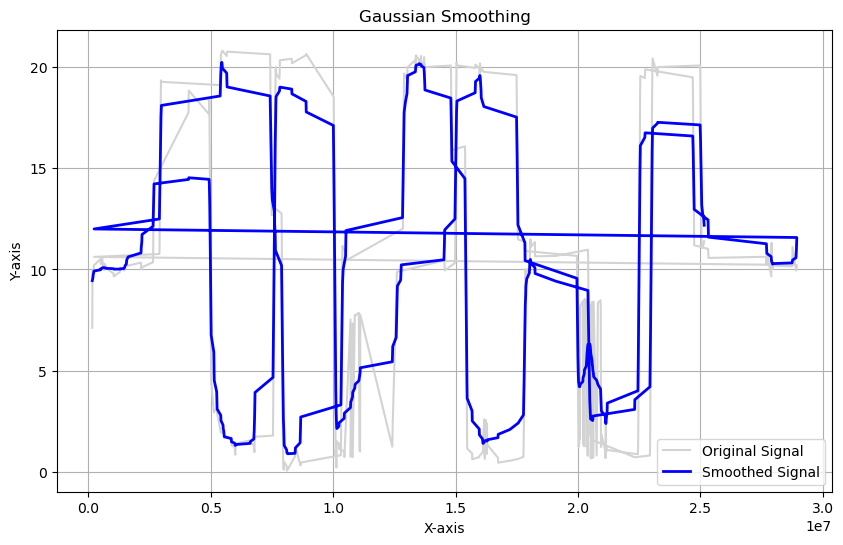

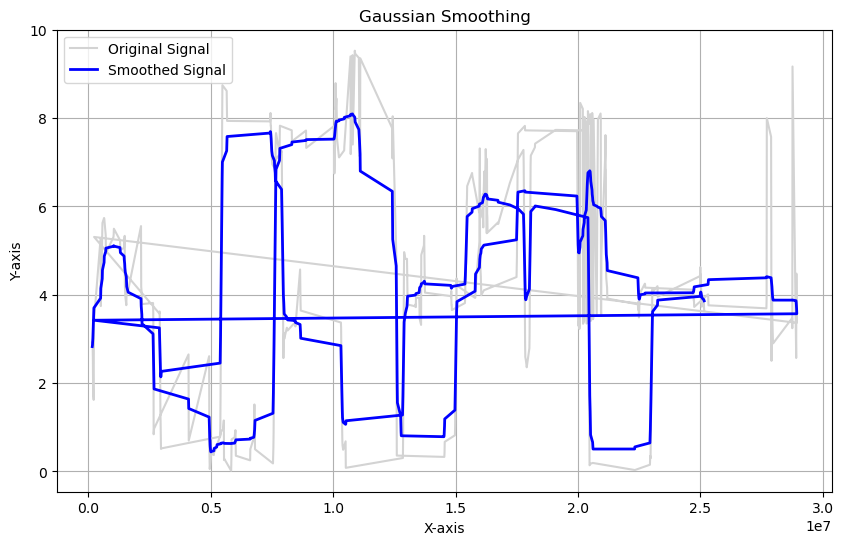

In [167]:
sigma = 5  # Standard deviation of the Gaussian kernel
y_smoothed = scipy.ndimage.gaussian_filter(dfSaccade['Gaze point X (MCSnorm)'], sigma=sigma)

plt.figure(figsize=(10, 6))

# Original signal
plt.plot(dfSaccade['Eyetracker timestamp'], dfSaccade['Gaze point X (MCSnorm)'], label='Original Signal', color='lightgray')

# Smoothed signal
plt.plot(dfSaccade['Eyetracker timestamp'], y_smoothed, label='Smoothed Signal', color='blue', linewidth=2)

plt.title('Gaussian Smoothing')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.show()

sigma = 5  # Standard deviation of the Gaussian kernel
y_smoothed = scipy.ndimage.gaussian_filter(dfSaccade['Gaze point Y (MCSnorm)'], sigma=sigma)

plt.figure(figsize=(10, 6))

# Original signal
plt.plot(dfSaccade['Eyetracker timestamp'], dfSaccade['Gaze point Y (MCSnorm)'], label='Original Signal', color='lightgray')

# Smoothed signal
plt.plot(dfSaccade['Eyetracker timestamp'], y_smoothed, label='Smoothed Signal', color='blue', linewidth=2)

plt.title('Gaussian Smoothing')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)

plt.show()


#check the downstream for the three features - 
#we know where the position is - 

### Extracting relevant features from data metric

### TODO: Identify number of saccades in each AOI manually and where they are

In [10]:
saccade_metrics_location = defaultdict(int)
saccade_metrics_number = defaultdict(int)

columns_to_keep = ['Gaze point X (MCSnorm)', 'Gaze point Y (MCSnorm)', 'Gaze point left X (MCSnorm)', 
                          'Gaze point left Y (MCSnorm)', 'Gaze point right X (MCSnorm)', 'Gaze point right Y (MCSnorm)']
for i in times_dict.keys():
    all_possible_hits = dfSaccade[dfSaccade[i] == np.max(dfSaccade[i])]

    total_saccades = 0
    df_saccades = pd.DataFrame()
    for index, row in all_possible_hits.iterrows(): 
        time = row['Eyetracker timestamp']
        #adding latency
        if (time/1000000 > (times_dict[i])+0.2) and (time/1000000 < (times_dict[i] + 2.5)):
            df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
        
            total_saccades +=1
    saccade_metrics_number[i] = total_saccades
    saccade_metrics_location[i] = df_saccades
  

saccade_metrics_location
saccade_metrics_number


/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_20005/1207306828.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_20005/1207306828.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_20005/1207306828.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_saccades = df_saccades.append(row[columns_to_keep], ignore_index=True)
/var/folders/q2/2f_m0ps1203czxrzbgwn59h80000gn/T/ipykernel_20005/1207306828.py:15: FutureWarning: The frame.append method is

defaultdict(int,
            {'AOI hit [slothStimulus-final (1) - sloth1]': 29,
             'AOI hit [slothStimulus-final (1) - sloth2]': 10,
             'AOI hit [slothStimulus-final (1) - sloth3]': 23,
             'AOI hit [slothStimulus-final (1) - sloth4]': 2,
             'AOI hit [slothStimulus-final (1) - sloth5]': 17,
             'AOI hit [slothStimulus-final (1) - sloth6]': 8,
             'AOI hit [slothStimulus-final (1) - sloth7]': 1,
             'AOI hit [slothStimulus-final (1) - sloth8]': 5,
             'AOI hit [slothStimulus-final (1) - sloth9]': 6,
             'AOI hit [slothStimulus-final (1) - sloth10]': 4,
             'AOI hit [slothStimulus-final (1) - sloth11]': 0,
             'AOI hit [catStimulus-final (1) - cat1]': 1,
             'AOI hit [catStimulus-final (1) - cat2]': 0,
             'AOI hit [catStimulus-final (1) - cat3]': 9,
             'AOI hit [catStimulus-final (1) - cat4]': 7,
             'AOI hit [catStimulus-final (1) - cat5]': 6,
     

In [11]:
# dataMetricSaccades = dataMetric.iloc[:,list(range(520, dataMetric.shape[1]))]


In [12]:
# dataMetricSaccades[['Number_of_saccades_in_AOI.bottomLeftCat1',
#        'Number_of_saccades_in_AOI.bottomLeftSloth',
#        'Number_of_saccades_in_AOI.bottomRightCat',
#        'Number_of_saccades_in_AOI.bottomRightCat2',
#        'Number_of_saccades_in_AOI.bottomRightSloth',
#        'Number_of_saccades_in_AOI.centerCat',
#        'Number_of_saccades_in_AOI.centerCat2',
#        'Number_of_saccades_in_AOI.centerSloth',
#        'Number_of_saccades_in_AOI.topCenterCat',
#        'Number_of_saccades_in_AOI.topCenterSloth',
#        'Number_of_saccades_in_AOI.topLeftCat',
#        'Number_of_saccades_in_AOI.topRightCat',
#        'Number_of_saccades_in_AOI.topRightSloth',
#        'Number_of_saccades_in_AOI.topRightSloth1',
#        'Time_to_entry_saccade.bottomLeftCat1']]

In [13]:
# dataMetricSaccades['Time_to_entry_saccade.centerCat2']